In [1]:
from pathlib import Path
from python.optimization import TopOpt2D, TopOpt3D
from python.postprocessor import Post2D, Post3D

ANSYS_path = Path("C:/Program Files/ANSYS Inc/v202/ansys/bin/winx64/MAPDL.exe")
script_dir = Path("python/")
res_dir    = Path("results/")
mod_dir    = Path("models/")
TopOpt2D.load_paths(ANSYS_path, script_dir, res_dir, mod_dir)
TopOpt2D.set_processors(4)

# Test case
- Half MBB 168 mm x 80 mm x 8 mm
- Mesh:
    - **2D**: 42 x 20 elements (4 mm element)
    - **3D**: 42 x 20 x 2 elements (4 mm element)
- 1 kN downward force


- Cellulose and 0.5 bamboo
- volfrac = 0.3
- r_rho = 6
- r_theta = 16
- theta0 = -70°
- 100 iterations

In [2]:
# fiber: bamboo
rhofiber  = 700e-12 # t/mm^3
Efiber    = 17.5e3 # MPa
vfiber    = 0.04
CO2fiber  = 1.0565 # kgCO2/kg

# matrix: cellulose
rhomatrix = 990e-12 # t/mm^3
Ematrix   = 3.25e3
vmatrix   = 0.355 # MPa
CO2matrix = 3.8 # kgCO2/kg

Vfiber  = 0.5
Vmatrix = 1-Vfiber

Gfiber  = Efiber/(2*(1+vfiber))
Gmatrix = Ematrix/(2*(1+vmatrix))

Ex   = Efiber*Vfiber + Ematrix*Vmatrix
Ey   = Efiber*Ematrix / (Efiber*Vmatrix + Ematrix*Vfiber)
Gxy  = Gfiber*Gmatrix / (Gfiber*Vmatrix + Gmatrix*Vfiber)
nuxy = vfiber*Vfiber + vmatrix*Vmatrix
rho  = rhofiber*Vfiber + rhomatrix*Vmatrix

CO2mat = (rhofiber*Vfiber*CO2fiber + rhomatrix*Vmatrix*CO2matrix)/rho # kgCO2/kg
CO2veh = 1030 * 25 * 3.83 # kg_fuel/kg_transported/year * years * kgCO2/kg_fuel = kgCO2/kg

In [3]:
solver1 = TopOpt2D(inputfile='mbb2d', Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=vmatrix, Gxy=Gxy, volfrac=0.3, r_rho=6, r_theta=16, theta0=-70, jobname='2d')
solver1.set_optim_options(max_iter=100, move_rho=0.4, move_theta=5)
solver1.optim()

print('\nElapsed time: {:.2f}s'.format(solver1.time))
print('FEA time: {:.2f}s'.format(solver1.mma.fea_time))

Starting iteration   1... compliance = 41670.5751
Starting iteration   2... compliance = 14808.9624
Starting iteration   3... compliance = 9166.8226
Starting iteration   4... compliance = 7072.9571
Starting iteration   5... compliance = 5854.7998
Starting iteration   6... compliance = 5126.2925
Starting iteration   7... compliance = 4737.3442
Starting iteration   8... compliance = 4539.4064
Starting iteration   9... compliance = 4466.5560
Starting iteration  10... compliance = 4598.1139
Starting iteration  11... compliance = 4561.1850
Starting iteration  12... compliance = 4610.5745
Starting iteration  13... compliance = 4567.7412
Starting iteration  14... compliance = 4560.3710
Starting iteration  15... compliance = 4489.9224
Starting iteration  16... compliance = 4474.8786
Starting iteration  17... compliance = 4423.7790
Starting iteration  18... compliance = 4311.5544
Starting iteration  19... compliance = 4141.8826
Starting iteration  20... compliance = 4093.5911
Starting iteration

CO2 footprint: 2686.60 kgCO2


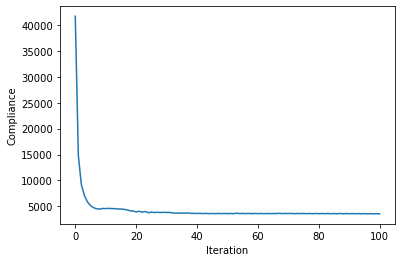

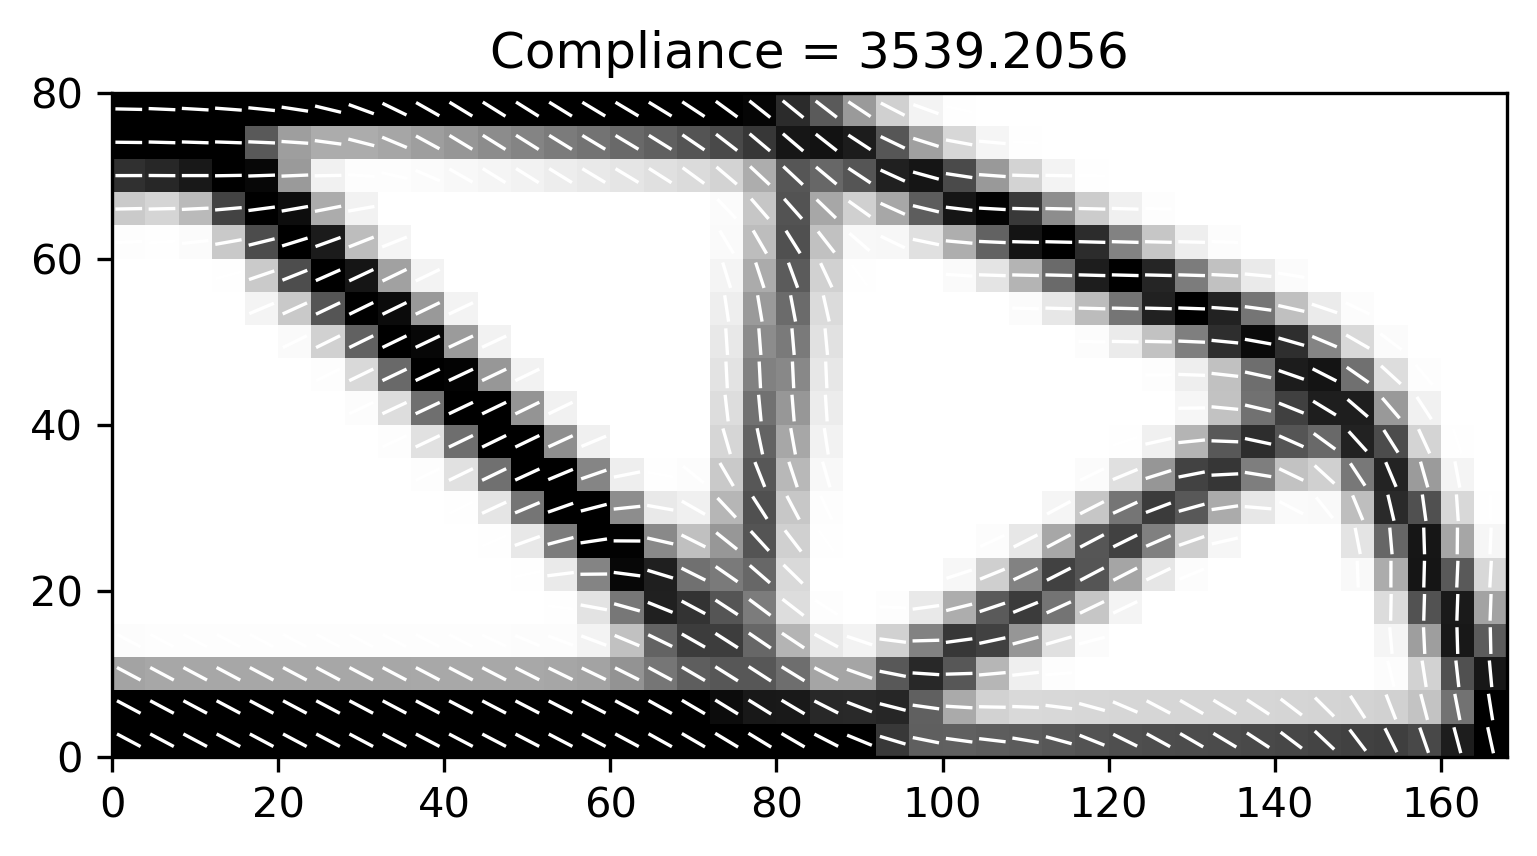

In [4]:
post1 = Post2D(solver1)
post1.plot_convergence()
post1.plot()

print('CO2 footprint: {:.2f} kgCO2'.format(1000 * post1.CO2_footprint(rho, CO2mat, CO2veh)))

In [5]:
solver2 = TopOpt3D(inputfile='mbb3d', Ex=Ex, Ey=Ey, nuxy=nuxy, nuyz=vmatrix, Gxy=Gxy, volfrac=0.3, r_rho=6, r_theta=16, theta0=-70, jobname='3d')
solver2.set_optim_options(max_iter=100, move_rho=0.4, move_theta=5)
solver2.optim()

print('\nElapsed time: {:.2f}s'.format(solver2.time))
print('FEA time: {:.2f}s'.format(solver2.mma.fea_time))

Starting iteration   1... compliance = 41645.0600
Starting iteration   2... compliance = 14672.6917
Starting iteration   3... compliance = 9032.6420
Starting iteration   4... compliance = 6966.7564
Starting iteration   5... compliance = 5781.4170
Starting iteration   6... compliance = 5122.7175
Starting iteration   7... compliance = 4800.4823
Starting iteration   8... compliance = 4781.4820
Starting iteration   9... compliance = 4658.1310
Starting iteration  10... compliance = 4796.9346
Starting iteration  11... compliance = 4688.6016
Starting iteration  12... compliance = 4749.9006
Starting iteration  13... compliance = 4649.9119
Starting iteration  14... compliance = 4659.6530
Starting iteration  15... compliance = 4560.4100
Starting iteration  16... compliance = 4592.7390
Starting iteration  17... compliance = 4398.2634
Starting iteration  18... compliance = 4278.9085
Starting iteration  19... compliance = 4140.5751
Starting iteration  20... compliance = 4184.1076
Starting iteration

CO2 footprint: 2589.79 kgCO2


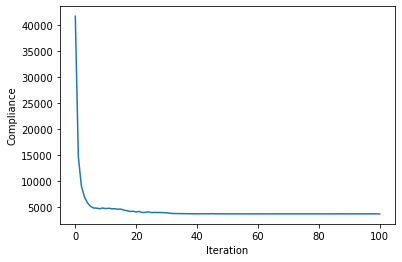

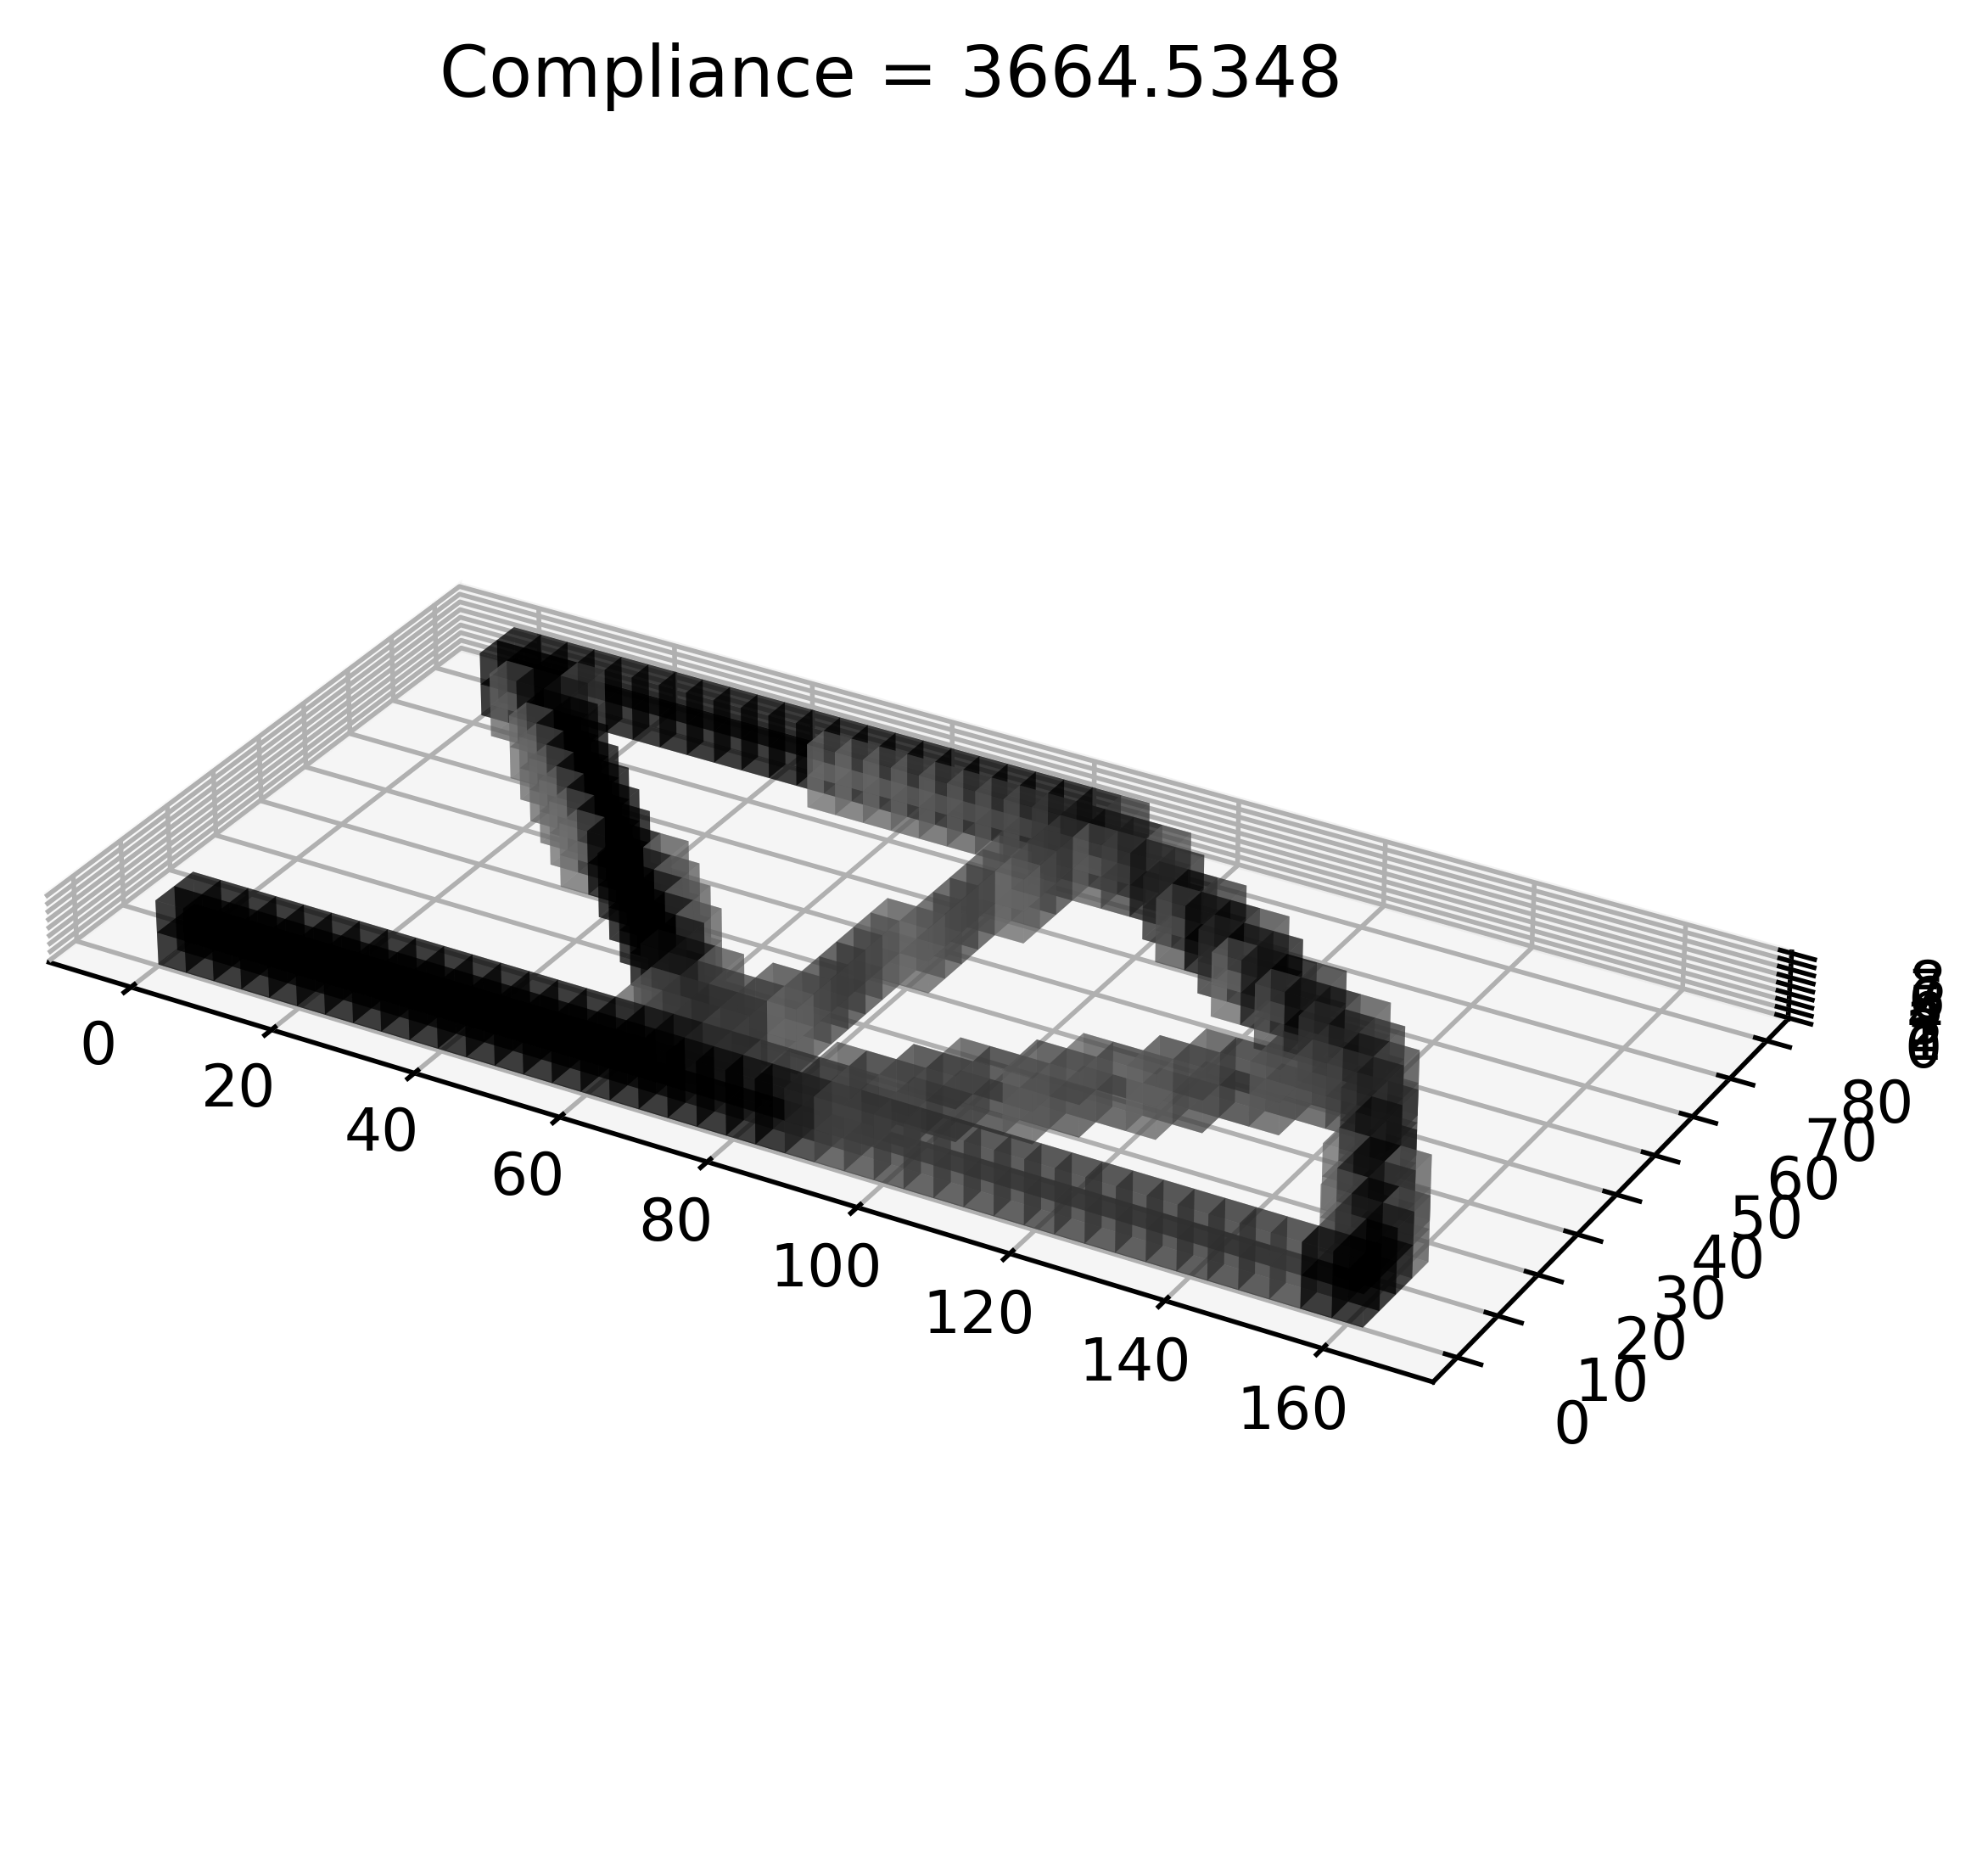

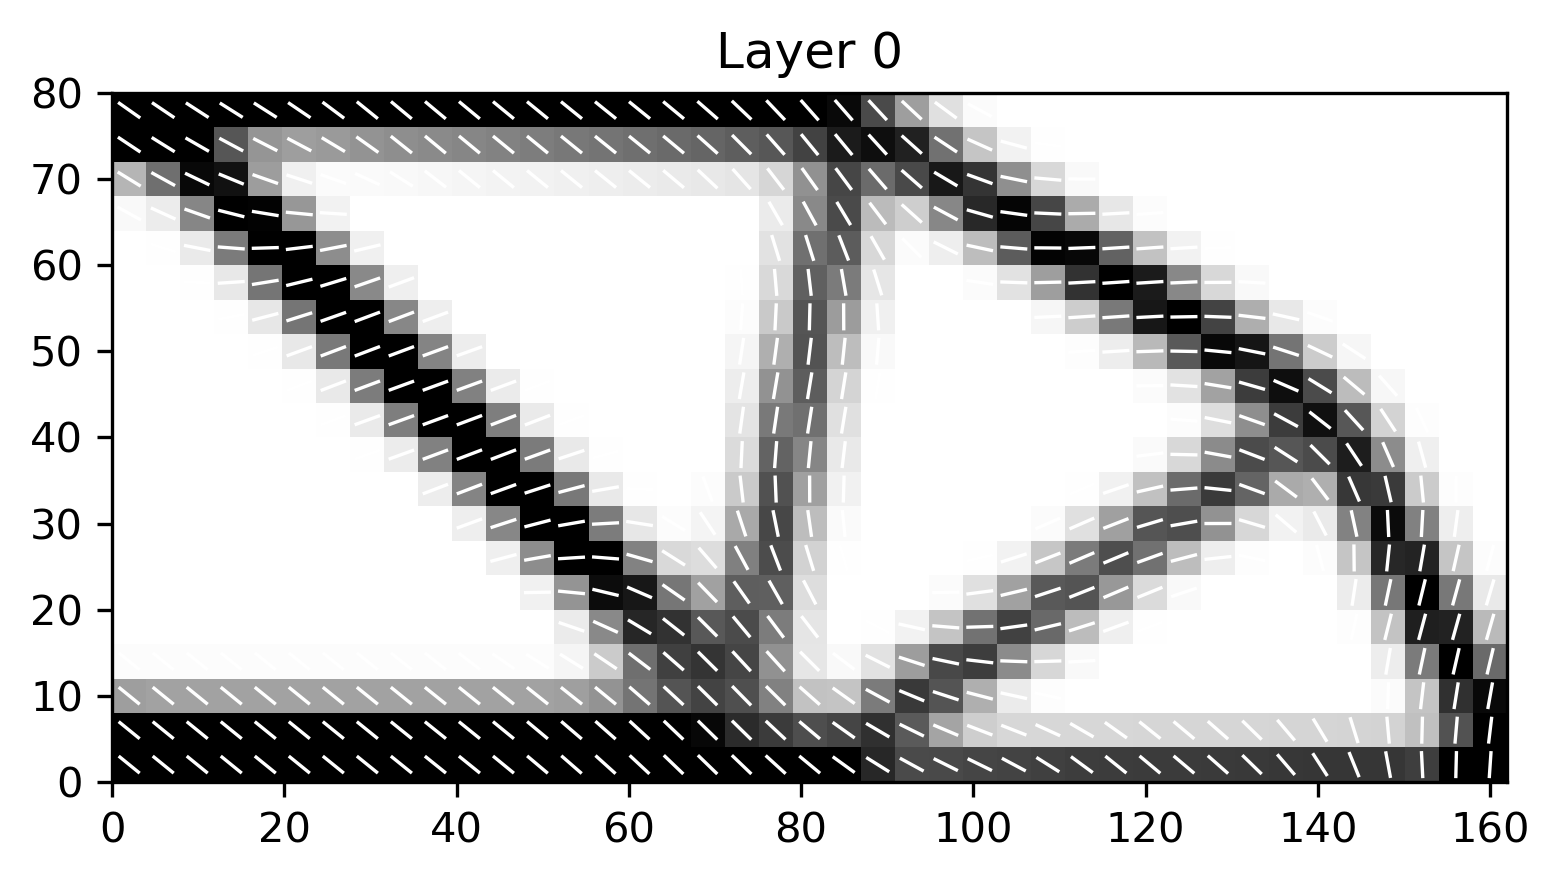

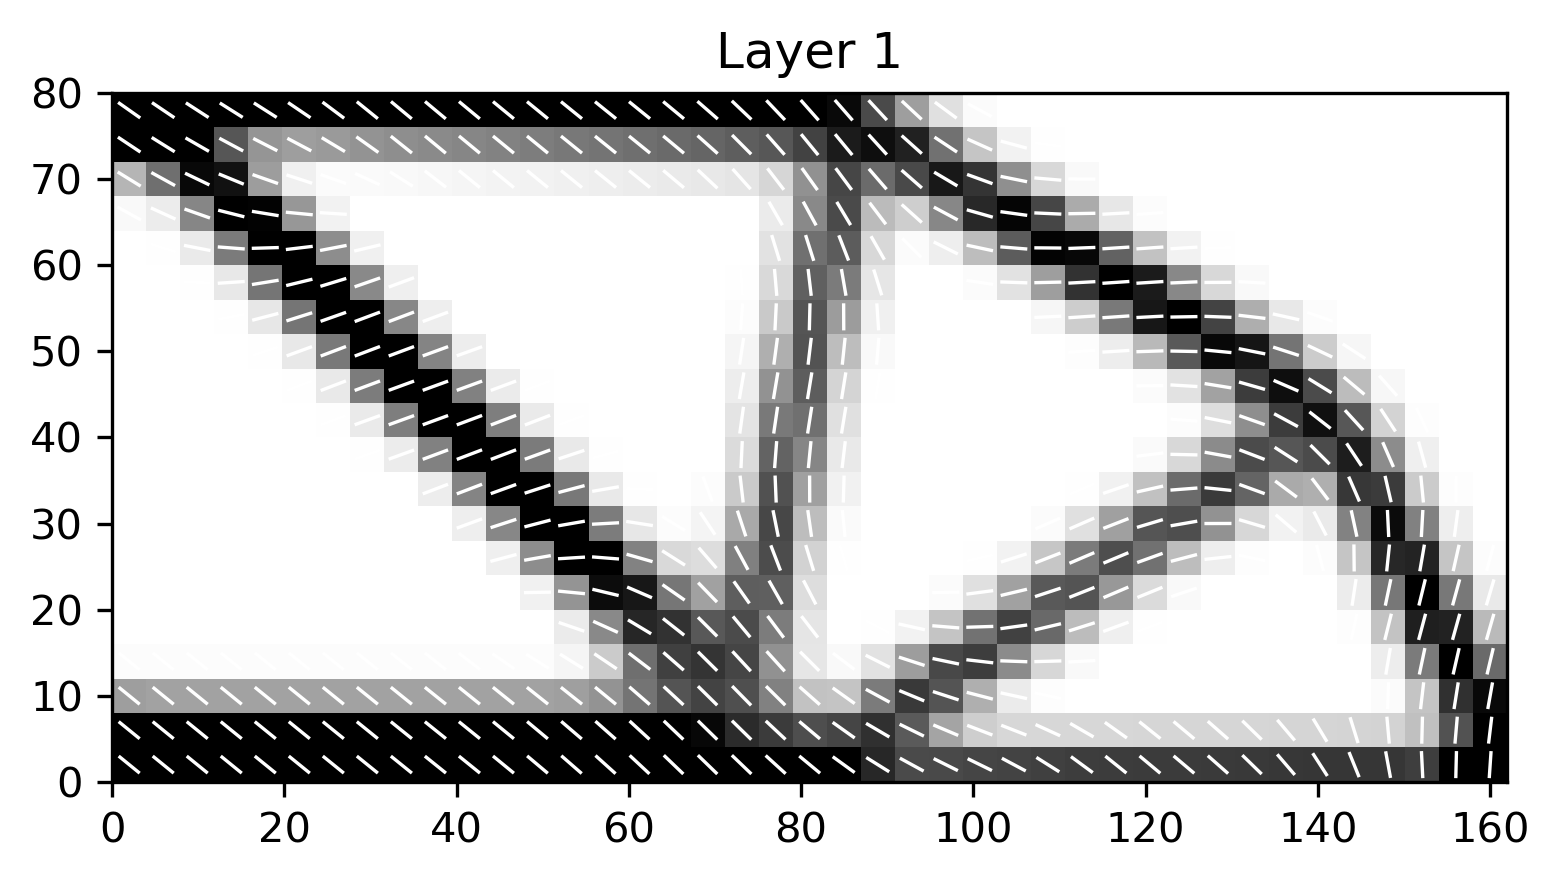

In [6]:
post2 = Post3D(solver2)
post2.plot_convergence()
post2.plot()
post2.plot_layer(layer=0)
post2.plot_layer(layer=1)

print('CO2 footprint: {:.2f} kgCO2'.format(1000 * post2.CO2_footprint(rho, CO2mat, CO2veh)))

In [7]:
# Clear temporary files
import os, glob
for filename in glob.glob("2d.*"): os.remove(filename)
for filename in glob.glob("3d.*"): os.remove(filename)